# STEMMUS_SCOPE BMI groundwater coupling
We have to choose how we want to run the BMI. We can do this either using a local executable file, or with a Docker container.

How to run the model is define in the configuration file.
If it has an entry "ExeFilePath" it will use the local executable. If this is missing, it wil try to use Docker (if docker-py is available). 

In [1]:
cfg_file = "/home/sarah/temp/ecoextreml/test/input/NL-Loo_2024-11-07-1226/NL-Loo_2024-11-07-1226_config.txt"
out_path = "/home/sarah/temp/ecoextreml/test/output/NL-Loo_2024-11-07-1226/"

If we are using the local executable file we first have to add the matlab runtime compiler locations to PATH:

In [2]:
from PyStemmusScope.config_io import read_config
import os
matlab_path = !whereis MATLAB
matlab_path = matlab_path.s.split(": ")[1]
os.environ['LD_LIBRARY_PATH'] = (
    f"{matlab_path}/MATLAB_Runtime/R2023a/runtime/glnxa64:"
    f"{matlab_path}/MATLAB_Runtime/R2023a/bin/glnxa64:"
    f"{matlab_path}/MATLAB_Runtime/R2023a/sys/os/glnxa64:"
    f"{matlab_path}/MATLAB_Runtime/R2023a/extern/bin/glnxa64:"
    f"{matlab_path}/MATLAB_Runtime/R2023a/sys/opengl/lib/glnxa64")
print(os.environ['LD_LIBRARY_PATH'])
os.environ["STEMMUS_SCOPE"] = read_config(cfg_file)["ExeFilePath"]

/usr/local/MATLAB/MATLAB_Runtime/R2023a/runtime/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/R2023a/bin/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/R2023a/sys/os/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/R2023a/extern/bin/glnxa64:/usr/local/MATLAB/MATLAB_Runtime/R2023a/sys/opengl/lib/glnxa64


Now we can initialize the model with a prepared configuration file:

In [3]:
from PyStemmusScope.bmi.implementation import StemmusScopeBmi
from cftime import num2pydate
from rich import print
import numpy as np
import xarray as xr
from pathlib import Path

model = StemmusScopeBmi()

model.initialize(cfg_file)

model.update()  # STEMMUS_SCOPE needs to be updated by one timestep before the BMI is accessible

After initialization we can enable the groundwater coupling. You enable this using the following command:

In [4]:
model.set_value("groundwater_coupling_enabled", np.array([False]))

In [5]:
# model.set_value("groundwater_elevation_top_aquifer", np.array([2000.]))
# model.set_value("groundwater_head_bottom_layer", np.array([1950.]))  # 50 cm under ground surface
# model.set_value("groundwater_temperature", np.array([23.])) # optional. 50 deg C here to get a high contrast

Now we can run the model. We define arrays to store the results that we want to inspect, and then step through all model timesteps:

In [6]:
n_timesteps = int((model.get_end_time() - model.get_current_time())/model.get_time_step())
n_soil_layers = model.get_grid_size(model.get_var_grid("soil_moisture"))

soil_moisture = np.zeros((n_timesteps, n_soil_layers))
soil_temperature = np.zeros((n_timesteps, n_soil_layers))
time = []
i=0


# while model.get_current_time() < model.get_end_time():
while i < 1200:
    model.get_value("soil_moisture", soil_moisture[i])
    model.get_value("soil_temperature", soil_temperature[i])

    # Store the current time as a datetime
    time.append(num2pydate(model.get_current_time(), model.get_time_units()))

    i+=1
    model.update()

print("model is done")


model is done

For easier anaylsis we can put the data into xarray DataArray objects:

In [6]:
# gs = model.get_grid_size(1)
# depths = np.ones(gs)
# model.get_grid_z(1, depths)

# da_sm = xr.DataArray(
#     data=soil_moisture,
#     dims=("time", "depth"),
#     coords={"time": np.array(time), "depth": depths},
# )
# da_sm.to_netcdf(path=f"{out_path}/soil_moisture.nc", mode='w')

# da_t = xr.DataArray(
#     data=soil_temperature,
#     dims=("time", "depth"),
#     coords={"time": np.array(time), "depth": depths},
# )
# da_t.to_netcdf(path=f"{out_path}/soil_temperature.nc", mode='w')

ValueError: conflicting sizes for dimension 'time': length 1487 on the data but length 0 on coordinate 'time'

In [8]:
num2pydate(model.get_end_time(), model.get_time_units())

real_datetime(2012, 2, 1, 0, 0)

In [9]:
n_timesteps

1487

In [7]:
model.finalize()

ValueError: Model terminated with return code None

Now we can show the results. Note that up to ~2.5 m depth the soil is completely saturated, and that the temperature here equals the groundwater temperature we defined before.

### plots

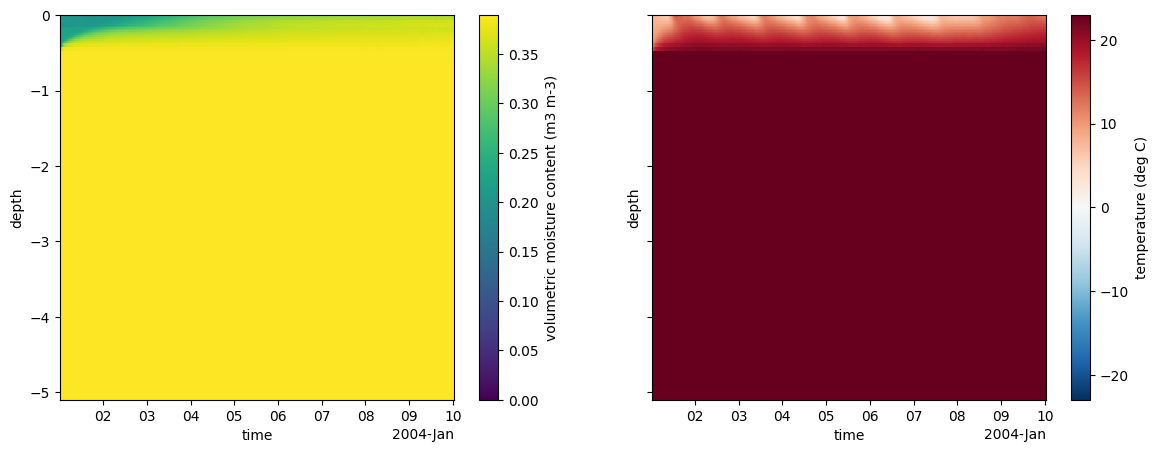

In [9]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14,5))
ax1.set_title("Soil Moisture")
ax2.set_title("Soil Temperature")
ax1.set_ylabel("depth (m)")
ax2.set_ylabel("depth (m)")
da_sm.plot(y="depth", ax=ax1, cbar_kwargs={'label': "volumetric moisture content (m3 m-3)"})
da_t.plot(y="depth", ax=ax2, cbar_kwargs={'label': "temperature (deg C)"})

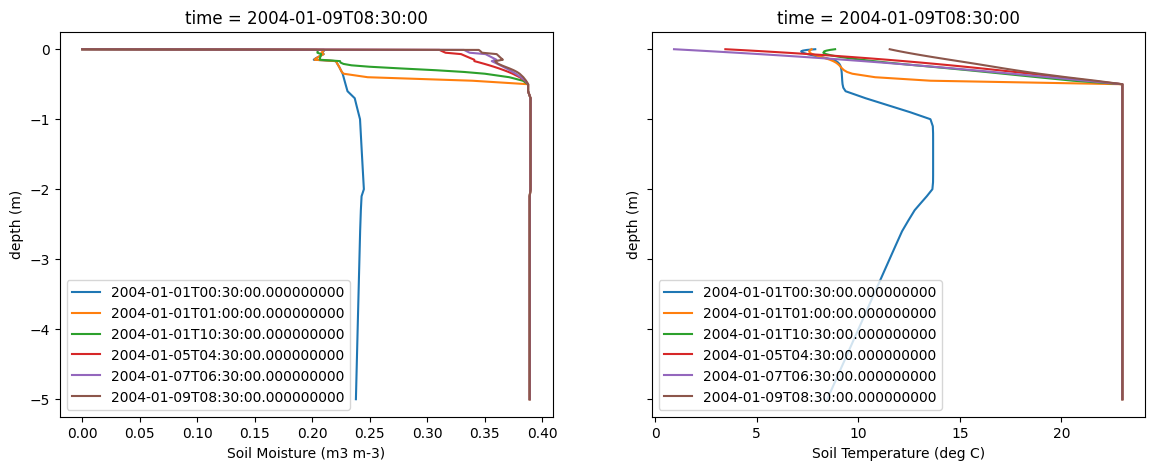

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(14,5))

for i in [0, 1, 20, 200, 300, 400]:
    label = da_t.isel(time=i).time.values
    da_sm.isel(time=i).plot(y="depth", ax=ax1, label=label)

ax1.set_xlabel("Soil Moisture (m3 m-3)")
ax1.set_ylabel("depth (m)")
ax1.legend()

for i in [0, 1, 20, 200, 300, 400]:
    label = da_t.isel(time=i).time.values
    da_t.isel(time=i).plot(y="depth", ax=ax2, label=label)

ax2.set_ylabel("depth (m)")
ax2.set_xlabel("Soil Temperature (deg C)")
ax2.legend()